# Name: Samar Miraj
# Roll Number: 253-CS-2019
# Section: E

### Import Libraries

In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.utils import layer_utils
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import keras
import warnings
warnings.filterwarnings("ignore")

### Load the Data

In [2]:
df = pd.read_csv("C:/Users/arsal/Desktop/mobile-smartphone-images-dataset/mobile_data_img.csv")

In [3]:
df.head()

,Label,Model,Brand,Condition,Image_File
0,apple iphone 7 portroid (used),iPhone 7,Apple,Used,mobile_images/1635051927882_Apple iPhone 7 Por...
1,apple iphone 6s 128gb (used),iPhone 6S,Apple,Used,mobile_images/1635051928230_Apple iPhone 6S 12...
2,samsung galaxy m02 (used),Galaxy M02,Samsung,Used,mobile_images/1635051928415_Samsung Galaxy M02...
3,lg q92 5g black snapdragon (new),Q92,LG,New,mobile_images/1635051928611_LG Q92 5G Black Sn...
4,apple iphone 7 128gb (used),iPhone 7,Apple,Used,mobile_images/1635051928818_Apple iPhone 7 128...


In [4]:
IMG_URL = "C:/Users/arsal/Desktop/mobile-smartphone-images-dataset/mobile_images/"

### EDA

In [5]:
# check stats of dataset
df.describe()

,Label,Model,Brand,Condition,Image_File
count,51195,51195,51195,51195,51195
unique,14616,646,39,2,51195
top,apple iphone 7 128gb (used),iPhone 7,Apple,Used,mobile_images/1635149395532_Samsung Galaxy Not...
freq,1173,3978,21431,41935,1


In [6]:
# Checking the null values 
df.isnull().sum()

Label         0
Model         0
Brand         0
Condition     0
Image_File    0
dtype: int64

### Data Visualization

In [7]:
def plot_12_random_images():
    _, axs = plt.subplots(3, 4, figsize=(12, 12))
    axs = axs.flatten()
    for ax in axs:
        idx = np.random.randint(0, len(df.index)-1)
        img = mpimg.imread(IMG_URL+df.iloc[idx]["Image_File"])
        ax.imshow(img)
        ax.set_xlabel(f"{df.iloc[idx]['Brand']} - {df.iloc[idx]['Model']}")
    plt.show()

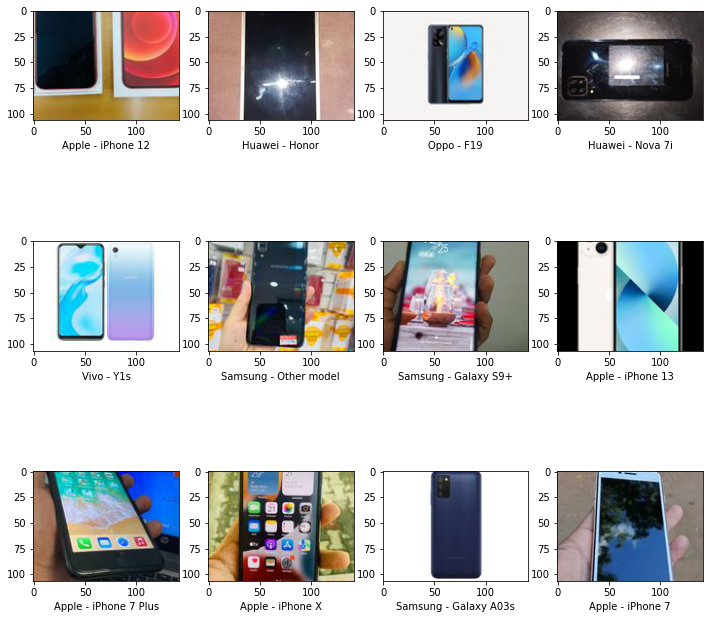

In [8]:
plot_12_random_images()

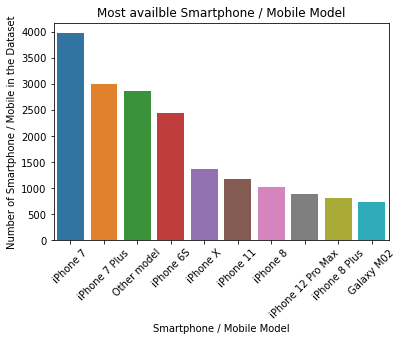

In [9]:
# Most available Smartphone / Mobile Model
top_phon_type = df[["Image_File", "Model"]].groupby("Model").agg(['count'])['Image_File']['count'].sort_values(ascending=False)[:10]
fig = sns.barplot( x = top_phon_type.index, y = top_phon_type.values)
fig.set_xticklabels(labels=top_phon_type.index , rotation=45)
fig.set_ylabel("Number of Smartphone / Mobile in the Dataset")
fig.set_xlabel("Smartphone / Mobile Model")
fig.set_title("Most availble Smartphone / Mobile Model");

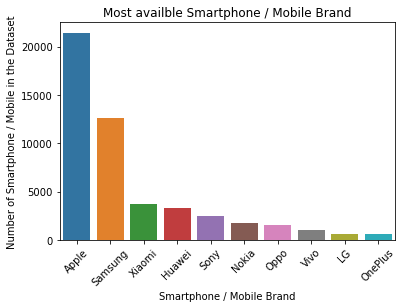

In [10]:
# Most available Smartphone / Mobile Brands
top_phon_type = df[["Image_File", "Brand"]].groupby("Brand").agg(['count'])['Image_File']['count'].sort_values(ascending=False)[:10]
fig = sns.barplot( x = top_phon_type.index, y = top_phon_type.values)
fig.set_xticklabels(labels=top_phon_type.index , rotation=45)
fig.set_ylabel("Number of Smartphone / Mobile in the Dataset")
fig.set_xlabel("Smartphone / Mobile Brand")
fig.set_title("Most availble Smartphone / Mobile Brand");

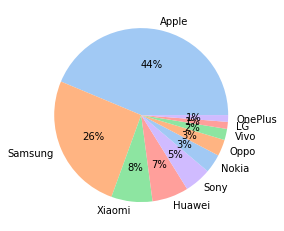

In [11]:
# Disrtribution of Brands among the Dataset
colors = sns.color_palette('pastel')[0:5]
plt.pie(top_phon_type, labels = top_phon_type.index, colors = colors, autopct='%.0f%%')
plt.show()

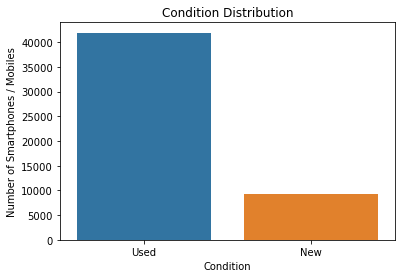

In [12]:
# Disrtribution of Smartphone / Mobile by condition in the Dataset
fig = sns.countplot(data= df, x="Condition")
fig.set_ylabel("Number of Smartphones / Mobiles")
fig.set_xlabel("Condition")
fig.set_title("Condition Distribution");

### Creating Train Test Split

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
df.Brand.value_counts()

Apple            21431
Samsung          12628
Xiaomi            3746
Huawei            3318
Sony              2441
Nokia             1713
Oppo              1497
Vivo              1013
LG                 639
OnePlus            615
Other brand        585
Realme             564
Infinix            205
Google             194
ZTE                120
Asus                84
HTC                 71
Greentel            48
E-tel               47
Moto                28
BlackBerry          28
Lenovo              27
Sony Ericsson       26
China Mobile        25
Micromax            18
Dialog              17
Alcatel             15
Acer                13
Microsoft           11
Sky                  7
Zigo                 5
iPro                 4
Ag-tel               4
i-mate               3
Megagate             1
HP                   1
Philips              1
Q Mobile             1
Dell                 1
Name: Brand, dtype: int64

In [15]:
# Filter out and consider imager with only minimum pf 90 images
f, u = pd.factorize(df.Brand)
df_filtered = df[np.bincount(f)[f] >= 4000]

### Label Encoding

In [16]:
from sklearn import preprocessing  
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()  
# Encode labels in column 'Brand'.
df_filtered['Brand']= label_encoder.fit_transform(df_filtered['Brand'])
df_filtered['Brand'].unique()

array([0, 1])

### Spliting Dataset

In [17]:
train, comb = train_test_split(df_filtered, test_size=0.3, shuffle = True, random_state = 42) # split training 
val, test = train_test_split(comb, test_size=0.50, shuffle = True, random_state = 42) # split training 
print("Training Count: "+str(len(train)))
print("Validation Count: "+str(len(val)))
print("Testing Count: "+str(len(test)))

Training Count: 23841
Validation Count: 5109
Testing Count: 5109


### Image Preprocessing

In [18]:
_dir = "C:/Users/arsal/Desktop/mobile-smartphone-images-dataset/mobile_images/"
train_data_gen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range = 110,
    shear_range = 0.15,
    zoom_range=0.15,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    fill_mode='nearest',
    cval=10,
    horizontal_flip=True,
    vertical_flip=True
    )
validation_data_gen = ImageDataGenerator(
    rescale = 1.0/255.,
    )
bs = 32
training_generator = train_data_gen.flow_from_dataframe(
    train, # labels
    _dir, # directory of the images
    x_col="Image_File", # name of the images with extension
    y_col="Brand", # labels
    class_mode="raw", # inferred from the labels
    color_mode = 'rgb',
    batch_size = bs,
    target_size=(300, 300))
validation_generator = train_data_gen.flow_from_dataframe(
    val, # labels
    _dir, # directory of the images
    x_col="Image_File", # name of the images with extension
    y_col="Brand", # inferred from the labels
    class_mode="raw",
    color_mode = 'rgb',
    batch_size=bs,
    target_size=(300, 300))

test_generator = train_data_gen.flow_from_dataframe(
    test, # labels
    _dir, # directory of the images
    x_col="Image_File", # name of the images with extension
    y_col="Brand", # inferred from the labels
    class_mode="raw",
    color_mode = 'rgb',
    batch_size=bs,
    target_size=(300, 300))

Found 23746 validated image filenames.
Found 5085 validated image filenames.
Found 5074 validated image filenames.


### Calling Pre Train Model Inception V3

In [19]:
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input
model = InceptionV3(input_shape=(300, 300, 3), weights='imagenet', include_top=False)

for layer in model.layers:
    layer.trainable = False
    
x = model.output
x = Flatten()(x)
x = Dense(12,activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(4,activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

In [20]:
main_model = Model(inputs=model.input, outputs=predictions)
main_model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)]

### Model Summary

In [21]:
main_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

### Training Model 

In [22]:
history = main_model.fit(
        training_generator,
        steps_per_epoch=100,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=5)

Epoch 1/10
100/100 [==============================] - 437s 4s/step - loss: 0.9066 - accuracy: 0.6169 - val_loss: 0.6858 - val_accuracy: 0.6250
Epoch 2/10
100/100 [==============================] - 494s 5s/step - loss: 0.6827 - accuracy: 0.6234 - val_loss: 0.6801 - val_accuracy: 0.6187
Epoch 3/10
100/100 [==============================] - 461s 5s/step - loss: 0.6760 - accuracy: 0.6300 - val_loss: 0.6766 - val_accuracy: 0.6125
Epoch 4/10
100/100 [==============================] - 500s 5s/step - loss: 0.6694 - accuracy: 0.6369 - val_loss: 0.6730 - val_accuracy: 0.6125
Epoch 5/10
100/100 [==============================] - 419s 4s/step - loss: 0.6662 - accuracy: 0.6334 - val_loss: 0.6596 - val_accuracy: 0.6500
Epoch 6/10
100/100 [==============================] - 422s 4s/step - loss: 0.6668 - accuracy: 0.6231 - val_loss: 0.6716 - val_accuracy: 0.6062
Epoch 7/10
100/100 [==============================] - 390s 4s/step - loss: 0.6634 - accuracy: 0.6288 - val_loss: 0.6847 - val_accuracy: 0.5688

### Plot of Training Accuracy vs Validation Accuracy

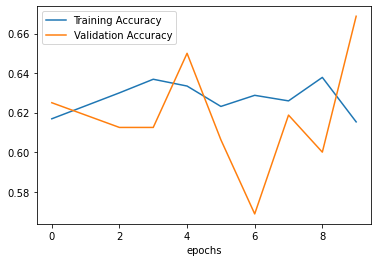

In [23]:
plt.plot(history.history['accuracy'],label="Training Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.legend()
plt.xlabel('epochs')
plt.show()